# Recurrent Residual Convolutional Neural Network

### Simon Laurent Lebailly, 2549365, s9sileba@teams.uni-saarland.de
### Christian Mathieu Schmidt, 2537621, s9cmscmi@teams.uni-saarland.de

## 1) Preliminaries

#### Import libaries

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import cityscapesscripts as cs

#### Use CUDA if possible

In [2]:
#Check if CUDA is available, if not use the CPU.
train_on_GPU = torch.cuda.is_available()
device = torch.device('cuda' if train_on_GPU else 'cpu')

if train_on_GPU:
    print('CUDA available!')
else:
    print('CUDA not available!')

CUDA available!


#### Define Hyperparameters

In [3]:
train = True
validate = True
evaluate = True

train_bs = 1
validation_bs = 1
test_bs = 1

epochs = 10

learning_rate = 0.0002

## 2) Data

#### Import dataset Cityscapes

In [4]:
import torchvision
from torchvision import transforms
from torchvision import datasets
from torch.utils import data


#Define normalization for dataset
normalize = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225]
)

#Define transformation for train, validation and test dataset
transform = transforms.Compose([
    transforms.Resize((256,512)),
    transforms.ToTensor(),
    normalize
])

class TransformToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        sample_out = (sample*32).long()
        return sample_out

target_transform = transforms.Compose([
    transforms.Resize((256,512)),
    transforms.ToTensor(),
    TransformToTensor()
])


#Path of dataset
root_path = 'C:/Users/chris/Documents/Cityscapes_dataset/Cityscapes'

if train:
    #Import dataset for training
    train_set = datasets.Cityscapes(root=root_path, split='train', mode='fine', target_type='semantic', transform=transform, target_transform=target_transform)
    quantity_train = len(train_set)
    print('Quantity training data: '+ str(quantity_train))

    #Prepare training dataset for NN
    train_loader = data.DataLoader(train_set, batch_size=train_bs, shuffle=True)

if validate or evaluate:
    #Import dataset for validation
    validation_set = datasets.Cityscapes(root=root_path, split='val', mode='fine', target_type='semantic', transform=transform, target_transform=target_transform)
    quantity_validation = len(validation_set)
    print('Quantity validation data: '+ str(quantity_validation))

    #Prepare validation dataset for NN
    validation_loader = data.DataLoader(validation_set, batch_size=validation_bs, shuffle=True)

if evaluate:
    #Import dataset for testing
    test_set = datasets.Cityscapes(root=root_path, split='test', mode='fine', target_type='semantic', transform=transform, target_transform=target_transform)
    quantity_test = len(test_set)
    print('Quantity testing data: '+ str(quantity_test))

    #Prepare test dataset for NN
    test_loader = data.DataLoader(test_set, batch_size=test_bs, shuffle=False)


Quantity validation data: 500
Quantity testing data: 1525


In [5]:
#Printouts for testing train set

#print(train_loader)
#print(validation_loader)
#print(test_loader)



#Tensor to image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


#img = cs.csViewer
#img, segm = train_set[32]
#print(img)
#print(segm.size())
#print(segm)
#segm_norm = segm
#segm_norm = segm
#print(segm_norm.size())
#targ_min = 32
#targ_max = 0
#for b in range(0, 1):
#    for r in range(0,256):
#        for c in range(0,512):
#            #if label_mask[b][r][c] >= 32:
#                #print("First eval: " + str(label_mask[b][r][c]) + ", " + str(b) + ", " + str(r) + ", " + str(c))
#            if segm_norm[b][r][c] > targ_max:
#                targ_max = segm_norm[b][r][c]
#            if segm_norm[b][r][c] < targ_min:
#                targ_min = segm_norm[b][r][c]
#print("targ_min: " + str(targ_min))
#print("targ_max: " + str(targ_max))

#segm_norm = (segm*8)/256
#print(segm_norm)
#print(img.size())

#imshow(torchvision.utils.make_grid(img))
#imshow(torchvision.utils.make_grid(segm))

#print(segm)
#segm.show()
#print(type(train_set))
#print(train_set)

## 3) Model

#### Define R2U-Net model

In [6]:
import torch
import torch.nn as nn


# For the model we use modified code from the source: https://github.com/LeeJunHyun/Image_Segmentation/blob/master/network.py

class conv_block(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(conv_block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=(3,3),stride=(1,1),padding=(1,1),bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=(3,3),stride=(1,1),padding=(1,1),bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)

        return x



class up_conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(up_conv, self).__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=(3,3),stride=(1,1),padding=(1,1),bias=False),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.up(x)

        return x



class Recurrent_block(nn.Module):
    def __init__(self, ch_out, t=2):
        super(Recurrent_block, self).__init__()

        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=(3,3),stride=(1,1),padding=(1,1),bias=False),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )


    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)

            x1 = self.conv(x+x1)

        return x1



class RRCNN_block(nn.Module):
    def __init__(self, ch_in, ch_out, t=2):
        super(RRCNN_block, self).__init__()

        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )

        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=(1,1),stride=(1,1),padding=(0,0))


    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)

        return x+x1



class R2U_Net(nn.Module):
    def __init__(self, img_ch=3, output_ch=34, t=3):
        super(R2U_Net, self).__init__()

        # Layers for down and up
        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        # Layers for encoding
        self.RRCNN1 = RRCNN_block(ch_in=img_ch, ch_out=64, t=t)
        self.RRCNN2 = RRCNN_block(ch_in=64, ch_out=128, t=t)
        self.RRCNN3 = RRCNN_block(ch_in=128, ch_out=256, t=t)
        self.RRCNN4 = RRCNN_block(ch_in=256, ch_out=512, t=t)
        self.RRCNN5 = RRCNN_block(ch_in=512, ch_out=1024, t=t)

        # Layers for decoding
        self.Up5 = up_conv(ch_in=1024, ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        self.Up4 = up_conv(ch_in=512, ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        self.Up3 = up_conv(ch_in=256, ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        self.Up2 = up_conv(ch_in=128, ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        # Convolution for output layer
        self.Conv_1x1 = nn.Conv2d(64, output_ch, kernel_size=(1,1), stride=(1,1), padding=(0,0))


    def encoding_image(self, input):
        """Left side of U (encoding of input image).
            @:param input image as tensor
            @:return list with every step of encoding
        """
        x1 = self.RRCNN1(input)
        x1_out = self.Maxpool(x1)

        x2 = self.RRCNN2(x1_out)
        x2_out = self.Maxpool(x2)

        x3 = self.RRCNN3(x2_out)
        x3_out = self.Maxpool(x3)

        x4 = self.RRCNN4(x3_out)
        out = self.Maxpool(x4)

        return x1, x2, x3, x4, out


    def decoding_image(self, bottleneck, encoded_image):
        """Right side of U (decoding) + Concatenation with the left U.
            @:param bottleneck of U-Net as tensor
            @:param list with encoding steps
            @:return decoded output tensor
        """
        x5 = torch.cat((encoded_image[3], self.Up5(bottleneck)), dim=1)
        x5_up = self.Up_RRCNN5(x5)

        x4 = torch.cat((encoded_image[2], self.Up4(x5_up)), dim=1)
        x4_up = self.Up_RRCNN4(x4)

        x3 = torch.cat((encoded_image[1], self.Up3(x4_up)), dim=1)
        x3_up = self.Up_RRCNN3(x3)

        x2 = torch.cat((encoded_image[0], self.Up2(x3_up)), dim=1)
        out = self.Up_RRCNN2(x2)

        return out


    def forward(self,x):
        # Encoding path
        encoded_image = self.encoding_image(x)

        # Bottleneck
        bottleneck = self.RRCNN5(encoded_image[4])

        # Decoding + concat path
        decoded_image = self.decoding_image(bottleneck, encoded_image)

        # Final output convolution
        out = self.Conv_1x1(decoded_image)

        return out

In [7]:
#Load model to device
r2u_net = R2U_Net().to(device)
print(r2u_net)


R2U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Upsample): Upsample(scale_factor=2.0, mode=nearest)
  (RRCNN1): RRCNN_block(
    (RCNN): Sequential(
      (0): Recurrent_block(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): Recurrent_block(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
    )
    (Conv_1x1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (RRCNN2): RRCNN_block(
    (RCNN): Sequential(
      (0): Recurrent_block(
        (conv): Sequential(
          (0): Conv2d(128, 

## 4) Loss and Optimizer

In [8]:
# loss function
criterion = nn.CrossEntropyLoss().to(device)

# optimizer variable
optimizer = torch.optim.Adam(r2u_net.parameters(), lr=learning_rate)

## 5) Train model

#### Definition train and validation loop

In [9]:
def show_statistics(epoch, batch_id, loss_actual, input_image, label_mask, output_model):
    print('[%d, %5d] train_loss: %.3f' % (epoch+1, batch_id+1, loss_actual.item()))

    # print images
    image2 = input_image.cpu()
    imshow(torchvision.utils.make_grid(image2[0]))

    label2 = label_mask.cpu()

    plt.imshow(label2.detach().numpy()[0])
    plt.show()

    output2 = output_model.cpu()
    output3 = output2.argmax(dim=1)

    plt.imshow(output3.detach().numpy()[0])
    plt.show()



def train_model(epoch, train_loader):
    trainloader_loop = tqdm(train_loader)
    printrate = int(quantity_train/(train_bs*10))
    train_loss = 0.0

    #Set model mode to train
    r2u_net.train()

    #Iterate over all batches in train_loader
    for i, batch in enumerate(trainloader_loop):
        #Input Image for forward pass
        input_image = batch[0].to(device)

        #Label "image" for comparing with loss function
        label_mask = batch[1].to(device)
        label_mask = label_mask.squeeze(1)

        #Forward propagation
        with torch.cuda.amp.autocast():
            output_model = r2u_net(input_image)

            loss = criterion(output_model, label_mask)

            #Print with loss
            train_loss += loss.item()
            if i % printrate == 0:
                show_statistics(epoch, i, loss, input_image, label_mask, output_model)

        #Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #update tqdm
        trainloader_loop.set_postfix(loss=loss.item())

    print("Finished training!")

    #Calculate validation_loss
    train_loss = train_loss/quantity_train
    
    return train_loss



def validate_model(epoch, validation_loader):
    validationloader_loop = tqdm(validation_loader)
    printrate = int(quantity_validation/(validation_bs*10))
    validation_loss = 0.0

    #Set model mode to evaluation
    r2u_net.eval()

    #Iterate over all batches in validation_loader
    for i, batch in enumerate(validationloader_loop):
        #Input Image for forward pass
        input_image = batch[0].to(device)

        #Label "image" for comparing with loss function
        label_mask = batch[1].to(device)
        label_mask = label_mask.squeeze(1)

        #Forward propagation
        with torch.no_grad():
            output_model = r2u_net(input_image)

            loss = criterion(output_model, label_mask)

            #Print with loss
            validation_loss += loss.item()
            if i % printrate == 0:
                show_statistics(epoch, i, loss, input_image, label_mask, output_model)

        #update tqdm
        validationloader_loop.set_postfix(loss=loss.item())

    print("Finished validation!")
    
    #Calculate validation_loss
    validation_loss = validation_loss/quantity_validation
    
    return validation_loss


#### Training and validation of the model

In [10]:
#Load parameters
file_name = 'savedata/task2/task_2_model_parameters-12_03_2021-04.pt'
if os.path.isfile(file_name):
    r2u_net = torch.load(file_name)

#Statistical parameters
train_loss = 0.0
train_loss_history = []
validation_loss = 0.0
validation_loss_history = []
learning_rate_history = []


#Iterate over every epoch
for epoch in range(epochs):
    #Train model
    if train:
        train_loss = train_model(epoch, train_loader)
        train_loss_history.append(train_loss)

    #Validate model
    if validate:
        validation_loss = validate_model(epoch, validation_loader)
        validation_loss_history.append(validation_loss)

    #Learning rate history
    learning_rate_history.append(learning_rate)

    torch.save(r2u_net, file_name)

print("Finished train model!")


Finished train model!


#### Print lists of mean losses and scheduled learning for every epoch

In [11]:
print("Train loss of every epoch: " + str(train_loss_history))
print("Validation loss of every epoch: " + str(validation_loss_history))
print("Learning rate of every epoch: " + str(learning_rate_history))

Train loss of every epoch: []
Validation loss of every epoch: []
Learning rate of every epoch: [0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002]


## 6) Evaluation

#### Evaluation metrics

In [12]:
import sklearn.metrics as metrics


def one_row(ground_truth, prediction):
    pred = prediction.argmax(dim=1).view(1,-1)
    pred = np.squeeze(pred.numpy())

    truth = ground_truth.view(1,-1)
    truth = np.squeeze(truth.numpy())

    return truth.astype(float), pred.astype(float)


def performance(multi_confusion_matrix, class_labels):
    true_positive = []
    false_positive = []
    true_negative = []
    false_negative = []

    for i in class_labels:
        true_positive.append(multi_confusion_matrix[i][[0],[0]][0])
        false_positive.append(multi_confusion_matrix[i][[0],[1]][0])
        true_negative.append(multi_confusion_matrix[i][[1],[1]][0])
        false_negative.append(multi_confusion_matrix[i][[1],[0]][0])

    positive = [true_positive, false_positive]
    negative = [true_negative, false_negative]

    return positive, negative


def evaluate(ground_truth, predictions):
    ground_truth2 = ground_truth.copy()
    predictions2 = predictions.copy()

    accuracy = 0.0
    f1_score = np.zeros(34, dtype='float')
    auc_score = 0.0
    dice_coefficient = 0.0

    listlen = min(len(ground_truth2),len(predictions2))

    for l in range(0, listlen):
        x = ground_truth2[l].cpu()
        y = predictions2[l].cpu()


        transform_tensors = one_row(x, y)

        class_labels = list(range(0, 34))

        multi_confusion_matrix = metrics.multilabel_confusion_matrix(transform_tensors[0], transform_tensors[1], labels=class_labels)

        performance_model = performance(multi_confusion_matrix, class_labels)

        positives = performance_model[0]
        negatives = performance_model[1]

        positives_total, negatives_total = 0,0
        true_positives, false_positives, true_negatives, false_negatives = 0,0,0,0

        for i in class_labels:
            positives_total += positives[0][i] + positives[1][i]
            negatives_total += negatives[0][i] + negatives[1][i]

            true_positives += positives[0][i]
            false_positives += positives[1][i]
            true_negatives += negatives[0][i]
            false_negatives += negatives[1][i]

        # Accuracy
        if (positives_total + negatives_total) != 0:
            accuracy += (true_positives + true_negatives) / (positives_total + negatives_total)


        # F1 score
        f1 = []
        for i in class_labels:
            denominator = 2 * positives[0][i] + positives[1][i] + negatives[1][i]
            if denominator != 0:
                f1.append(2 * positives[0][1] / denominator)
            else:
                f1.append(0.0)

        f1_score += f1


        # AUC-ROC score
        #auc_score += metrics.roc_auc_score(transform_tensors[0], transform_tensors[1], multi_class='ovr', labels=class_labels)


        # DICE coefficient
        if (2 * true_positives + false_positives + false_negatives) != 0:
            dice_coefficient += (2 * true_positives) / (2 * true_positives + false_positives + false_negatives)


    accuracy = accuracy / listlen
    f1_score = f1_score / listlen
    auc_score = auc_score / listlen
    dice_coefficient = dice_coefficient / listlen

    return accuracy, f1_score, auc_score, dice_coefficient

#### Evaluation

In [13]:
f1_score = -1000.0
auc_score = -1000.0
dice_coefficient = -1000.0

truth_list = []
pred_list = []

In [14]:
file_name = 'savedata/task2/task_2_model_parameters-12_03_2021-04.pt'
if os.path.isfile(file_name):
    r2u_net = torch.load(file_name)

#Only during the programming. We dont want want to build the testlist every time
breaker = False

if evaluate:
    testloader_loop = tqdm(validation_loader)

    #Set model mode to evaluation
    r2u_net.eval()

    #Iterate over all batches in test_loader
    for i, batch in enumerate(testloader_loop):
        if breaker:
            break
        #Input Image for forward pass
        test_image = batch[0].to(device)

        #Label "image" for comparing with loss function
        ground_truth = batch[1].cpu()
        ground_truth = ground_truth.squeeze(1)

        #Forward propagation
        with torch.no_grad():
            prediction = r2u_net(test_image)

        truth_list.append(ground_truth.float())
        pred_list.append(prediction.cpu().float())

    scores = evaluate(truth_list, pred_list)

    accuracy = scores[0]
    f1_score = scores[1]
    auc_score = scores[2]
    dice_coefficient = scores[3]

    print("Finished evaluation!")

100%|██████████| 1525/1525 [04:05<00:00,  6.22it/s]


Finished evaluation!


#### Print lists of scores

In [15]:
print("Accuracy: " + str(round((accuracy*100), 2)) + "%")
print("F1 score: " + str(f1_score*100) + "%")
print("AUC score: " + str(round((auc_score*100), 2)) + "%")
print("DICE coefficient: " + str(round((dice_coefficient*100), 2)) + "%")

Accuracy: 95.56%
F1 score: [160.04571027  72.66546807  60.6715067   66.86766147  57.68724836
  57.68724836  57.68724836  57.68724836  57.68724836  57.68724836
  57.68724836  57.68724836  57.68724836  57.68724836  57.68724836
  57.68724836  57.68724836  57.68724836  57.68724836  57.68724836
  57.68724836  57.68724836  57.68724836  57.68724836  57.68724836
  57.68724836  57.68724836  57.68724836  57.68724836  57.68724836
  57.68724836  57.68724836  57.68724836  57.68724836]%
AUC score: 0.0%
DICE coefficient: 97.71%


#### Evaluation plots

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

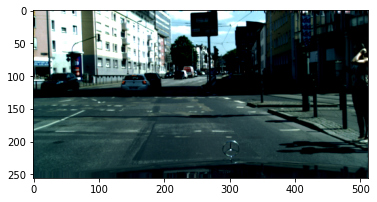

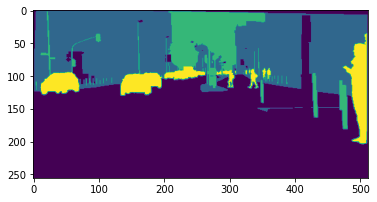

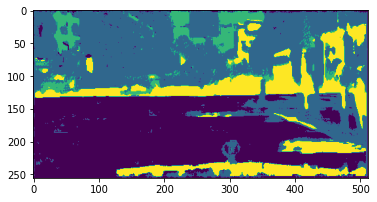

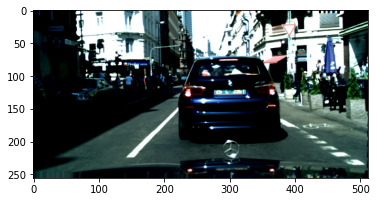

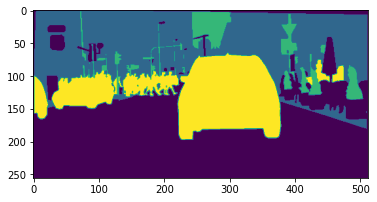

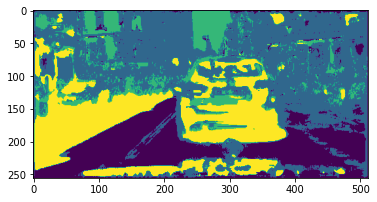

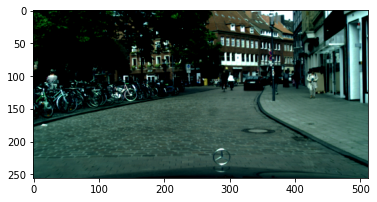

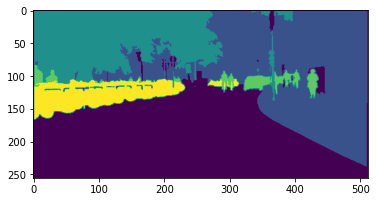

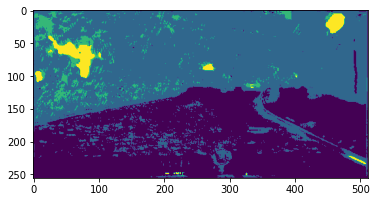

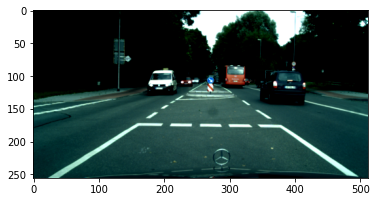

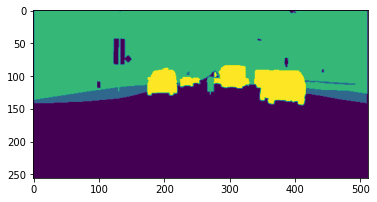

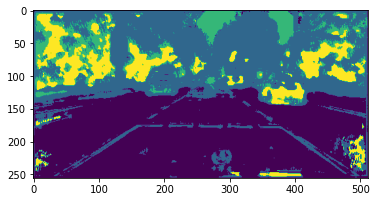

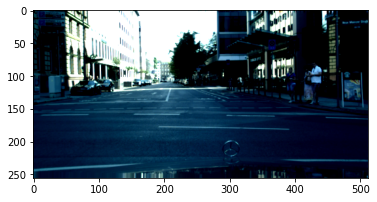

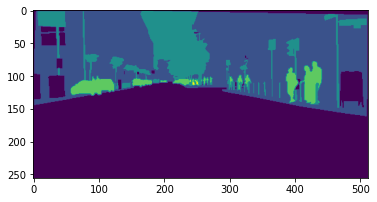

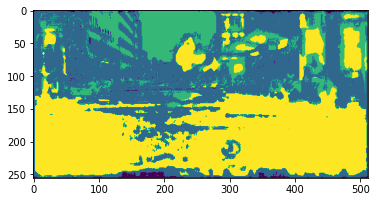

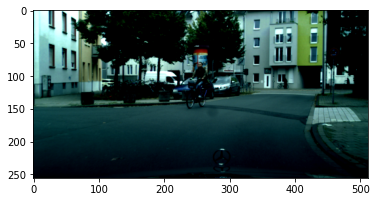

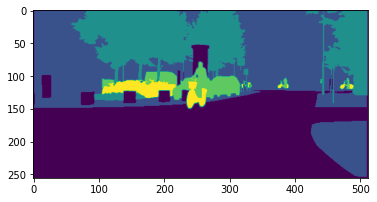

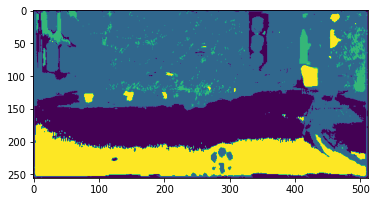

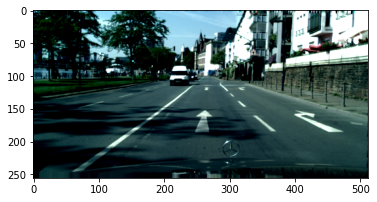

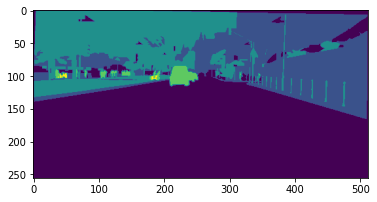

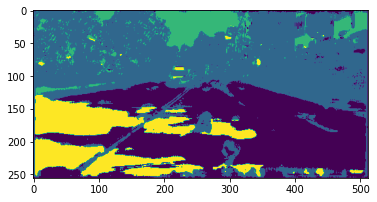

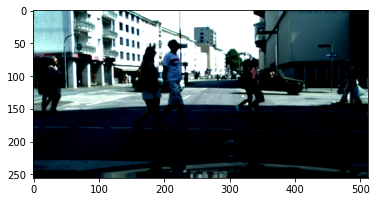

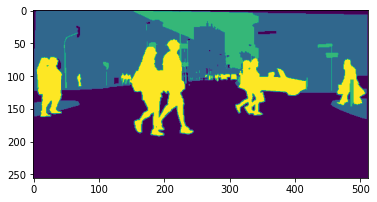

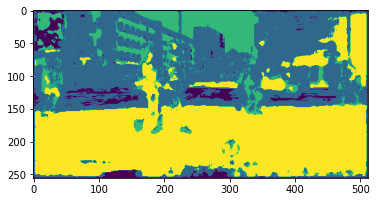

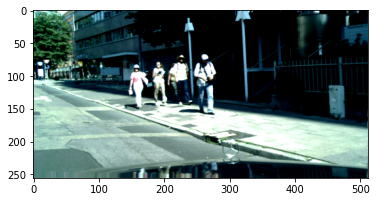

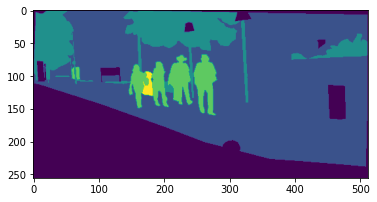

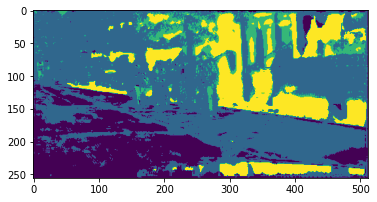

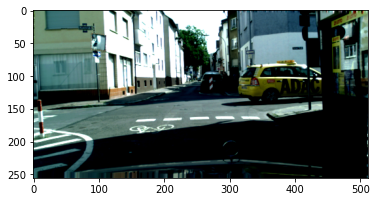

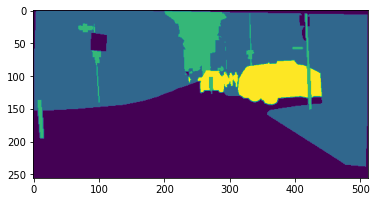

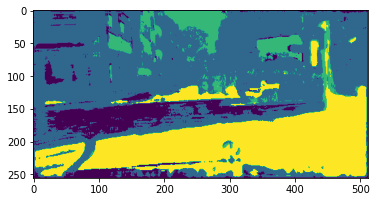

In [16]:
r2u_net.eval()

testloader_loop = tqdm(validation_loader)

for i, batch in enumerate(testloader_loop):
    if i % 10 == 0:
        input_image = batch[0].to(device)
        label_mask = batch[1].squeeze(1)

        with torch.no_grad():
            output_model = r2u_net(input_image.to(device))

        # print images
        image2 = input_image.cpu()
        imshow(torchvision.utils.make_grid(image2[0]))

        label2 = label_mask.cpu()

        plt.imshow(label2.detach().numpy()[0])
        plt.show()

        output2 = output_model.cpu()
        output3 = output2.argmax(dim=1)

        plt.imshow(output3.detach().numpy()[0])
        plt.show()

